In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("drive/My Drive/MSBA/Advanced Machine Learning/Team Project/")

Mounted at /content/drive


In [12]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
# from keras.engine.network import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

import pandas as pd

%matplotlib inline

## Config

In [3]:
### Constants ###
DATA_DIR = "./tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

## Dataset

The Dataset we used is Tiny ImageNet Visual Recognition Challenge. It can be downloaded [here](https://drive.google.com/drive/folders/1R9nEM3cBXgYbnG_LBmASNvgthtSfaF8_?usp=sharing).

Our training set is made of a random subset of images from all 200 classes.

In [4]:
def load_dataset_small(num_images_per_class_train=3, num_images_test=20):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [5]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 600
Number of test examples = 600
X_train shape: (600, 64, 64, 3)


In [6]:
# No. of Secret Images
n_secret = 2
input_S_list = []
n_idx = X_train.shape[0] // (n_secret+1)
at_idx = 0
for i in range(n_secret):
    input_S = X_train[at_idx:at_idx+n_idx]
    print(f"Secret {i} shape --> ", input_S.shape)
    input_S_list.append(input_S)
    at_idx +=n_idx

# C: cover image
input_C = X_train[at_idx:]
print("Cover image shape --> ",input_C.shape)

Secret 0 shape -->  (200, 64, 64, 3)
Secret 1 shape -->  (200, 64, 64, 3)
Cover image shape -->  (200, 64, 64, 3)


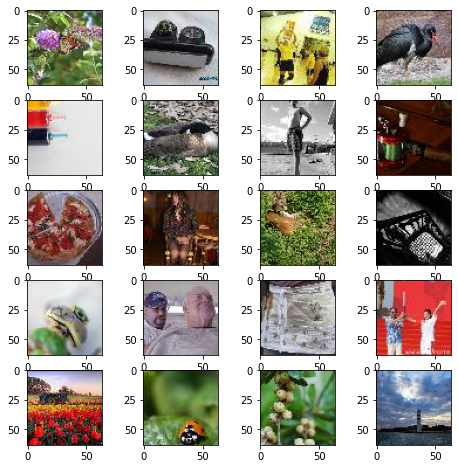

In [7]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

## Model

In [8]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def reveal_network_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_network_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = reveal_network_loss(s_true, s_pred)
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size, n_secret = 1):
#     input_S = Input(shape=(input_size))
    input_S_list = []
    input_C= Input(shape=(input_size))
    
    secret_images = []
    # Preparation Network for n secret images
    for i in range(n_secret):
        input_S = Input(shape=(input_size))
        input_S_list.append(input_S)
        x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name=f'conv_prep_{i}_0_3x3')(input_S)
        x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name=f'conv_prep_{i}_0_4x4')(input_S)
        x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name=f'conv_prep_{i}_0_5x5')(input_S)
        x = concatenate([x3, x4, x5])
    
        x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name=f'conv_prep_{i}_1_3x3')(x)
        x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name=f'conv_prep_{i}_1_4x4')(x)
        x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name=f'conv_prep_{i}_1_5x5')(x)
        secret = concatenate([x3, x4, x5])
        secret_images.append(secret)
    
    x = concatenate([input_C] + secret_images)
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name=f'conv_hid_0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name=f'conv_hid_0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name=f'conv_hid_0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name=f'conv_hid_1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name=f'conv_hid_1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name=f'conv_hid_1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name=f'conv_hid_2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name=f'conv_hid_2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name=f'conv_hid_2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name=f'conv_hid_3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name=f'conv_hid_3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name=f'conv_hid_3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name=f'conv_hid_4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name=f'conv_hid_4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name=f'conv_hid_5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    
    return Model(inputs=input_S_list+[input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')


def make_decoders(input_size, n_secret=1):
    decoder_list = []
    for i in range(n_secret):
        decoder = make_decoder(input_size, i)
        decoder_list.append(decoder)
    return decoder_list

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, i, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = f'Decoder_{i}')
    else:
        return Model(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size, n_secret = 1):
    input_S_l = []
    for _ in range(n_secret):
        input_S = Input(shape=(input_size))
        input_S_l.append(input_S)
    input_C=Input(shape=(input_size))
    
    encoder = make_encoder(input_size, n_secret=n_secret)
    
    decoders = make_decoders(input_size, n_secret=n_secret)
    
    output_Sprime_l = []
    for decoder in decoders:

        decoder.compile(optimizer='adam', loss=reveal_network_loss)
        decoder.trainable = False

        output_Cprime = encoder(input_S_l + [input_C])
        output_Sprime = decoder(output_Cprime)
        output_Sprime_l.append(output_Sprime)

    autoencoder = Model(inputs=input_S_l + [input_C],
                        outputs=concatenate(output_Sprime_l+[output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_network_loss)
    
    return encoder, decoders, autoencoder

In [9]:
encoder_model, reveal_models, autoencoder_model = make_model(input_S.shape[1:], n_secret=n_secret)

In [10]:
# Save model
def save_model(autoencoder_model):
    # serialize model to JSON
    model_json = autoencoder_model.to_json()
    filename = f"multi_steg.json"
    with open(filename, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    filename_weights = f"multi_steg_weights.h5"
    autoencoder_model.save_weights(filename_weights)
    print("Saved model to disk")

## Training

Although the author of the paper didn't explicitly described the learning rate schedule or the optimizer properties, we used our own schedule with ADAM optimizer. We train for 1000 epochs with a batch size of 32. 

In [11]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [13]:
# NB_EPOCHS = 1000
# BATCH_SIZE = 32

NB_EPOCHS = 1000
BATCH_SIZE = 32

m = input_S.shape[0]
loss_history = []
reveal_loss_history = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        batch_S_list = []
        for i, input_S in enumerate(input_S_list):
            batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
            batch_S_list.append(batch_S)
            
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict(batch_S_list + [batch_C])
        
        ae = autoencoder_model.train_on_batch(x=batch_S_list + [batch_C], y=concatenate(batch_S_list + [batch_C]))
        ae_loss.append(ae)
        
        inner_list = []
        for batch_S, reveal_model in zip(batch_S_list, reveal_models):
            reveal_loss = reveal_model.train_on_batch(x=C_prime, y=batch_S)
            inner_list.append(reveal_loss)
        rev_loss.append(np.mean(inner_list))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    
    loss_history.append(np.mean(ae_loss))
    reveal_loss_history.append(np.mean(rev_loss))
    if (epoch+1) % 20 == 0:
      save_model(autoencoder_model=autoencoder_model)
      pd.Series(loss_history).to_csv("loss_history.csv")
      pd.Series(reveal_loss_history).to_csv("reveal_loss_history.csv")
    

Epoch 1 | Batch: 192 of 200. Loss AE  203843.86 | Loss Rev  101919.31: 100%|██████████| 7/7 [00:37<00:00,  5.30s/it]
Epoch 2 | Batch: 192 of 200. Loss AE   85644.91 | Loss Rev   42824.75: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
Epoch 3 | Batch: 192 of 200. Loss AE   69367.71 | Loss Rev   34682.03: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 4 | Batch: 192 of 200. Loss AE   47996.54 | Loss Rev   23998.74: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 5 | Batch: 192 of 200. Loss AE   41992.69 | Loss Rev   20991.93: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 6 | Batch: 192 of 200. Loss AE   41725.60 | Loss Rev   20864.31: 100%|██████████| 7/7 [00:12<00:00,  1.81s/it]
Epoch 7 | Batch: 192 of 200. Loss AE   39121.15 | Loss Rev   19563.12: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 8 | Batch: 192 of 200. Loss AE   38204.75 | Loss Rev   19106.21: 100%|██████████| 7/7 [00:12<00:00,  1.81s/it]
Epoch 9 | Batch: 192 of 200. Loss AE   35983.07 | Loss Rev   179

Saved model to disk


Epoch 21 | Batch: 192 of 200. Loss AE   15268.55 | Loss Rev    7634.94: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 22 | Batch: 192 of 200. Loss AE   13697.58 | Loss Rev    6849.16: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 23 | Batch: 192 of 200. Loss AE   13167.05 | Loss Rev    6584.22: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 24 | Batch: 192 of 200. Loss AE   12854.53 | Loss Rev    6428.85: 100%|██████████| 7/7 [00:12<00:00,  1.81s/it]
Epoch 25 | Batch: 192 of 200. Loss AE   13558.47 | Loss Rev    6778.30: 100%|██████████| 7/7 [00:12<00:00,  1.81s/it]
Epoch 26 | Batch: 192 of 200. Loss AE   15340.95 | Loss Rev    7671.56: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 27 | Batch: 192 of 200. Loss AE   15163.16 | Loss Rev    7582.54: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 28 | Batch: 192 of 200. Loss AE   18507.03 | Loss Rev    9253.48: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
Epoch 29 | Batch: 192 of 200. Loss AE   15463.33 | Loss 

Saved model to disk


Epoch 41 | Batch: 192 of 200. Loss AE   10644.93 | Loss Rev    5322.54: 100%|██████████| 7/7 [00:12<00:00,  1.81s/it]
Epoch 42 | Batch: 192 of 200. Loss AE   10523.99 | Loss Rev    5261.68: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 43 | Batch: 192 of 200. Loss AE   10586.45 | Loss Rev    5293.85: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 44 | Batch: 192 of 200. Loss AE   10898.44 | Loss Rev    5449.86: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 45 | Batch: 192 of 200. Loss AE   10697.55 | Loss Rev    5348.20: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 46 | Batch: 192 of 200. Loss AE   10537.25 | Loss Rev    5268.78: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
Epoch 47 | Batch: 192 of 200. Loss AE   10073.40 | Loss Rev    5035.77: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 48 | Batch: 192 of 200. Loss AE    9972.21 | Loss Rev    4985.73: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 49 | Batch: 192 of 200. Loss AE    9857.93 | Loss 

Saved model to disk


Epoch 61 | Batch: 192 of 200. Loss AE    8799.26 | Loss Rev    4399.25: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
Epoch 62 | Batch: 192 of 200. Loss AE    8746.41 | Loss Rev    4373.75: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 63 | Batch: 192 of 200. Loss AE    8898.36 | Loss Rev    4450.18: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 64 | Batch: 192 of 200. Loss AE    8986.22 | Loss Rev    4492.39: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 65 | Batch: 192 of 200. Loss AE    9666.09 | Loss Rev    4832.78: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 66 | Batch: 192 of 200. Loss AE    8497.28 | Loss Rev    4248.62: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 67 | Batch: 192 of 200. Loss AE    8606.87 | Loss Rev    4302.66: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 68 | Batch: 192 of 200. Loss AE    8308.72 | Loss Rev    4154.45: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 69 | Batch: 192 of 200. Loss AE    8379.10 | Loss 

Saved model to disk


Epoch 81 | Batch: 192 of 200. Loss AE    7980.43 | Loss Rev    3990.48: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 82 | Batch: 192 of 200. Loss AE    7736.87 | Loss Rev    3868.22: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 83 | Batch: 192 of 200. Loss AE    7921.93 | Loss Rev    3961.72: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 84 | Batch: 192 of 200. Loss AE    8505.00 | Loss Rev    4251.74: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 85 | Batch: 192 of 200. Loss AE    9060.55 | Loss Rev    4530.02: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 86 | Batch: 192 of 200. Loss AE    8420.04 | Loss Rev    4209.78: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 87 | Batch: 192 of 200. Loss AE    8937.44 | Loss Rev    4468.99: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 88 | Batch: 192 of 200. Loss AE    9625.64 | Loss Rev    4812.70: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 89 | Batch: 192 of 200. Loss AE   14693.42 | Loss 

Saved model to disk


Epoch 101 | Batch: 192 of 200. Loss AE    6639.97 | Loss Rev    3320.49: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 102 | Batch: 192 of 200. Loss AE    6502.53 | Loss Rev    3250.70: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 103 | Batch: 192 of 200. Loss AE    6472.73 | Loss Rev    3236.27: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 104 | Batch: 192 of 200. Loss AE    7045.09 | Loss Rev    3523.08: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 105 | Batch: 192 of 200. Loss AE    9297.62 | Loss Rev    4649.52: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 106 | Batch: 192 of 200. Loss AE    8583.92 | Loss Rev    4293.00: 100%|██████████| 7/7 [00:13<00:00,  1.92s/it]
Epoch 107 | Batch: 192 of 200. Loss AE    8343.80 | Loss Rev    4171.50: 100%|██████████| 7/7 [00:13<00:00,  1.94s/it]
Epoch 108 | Batch: 192 of 200. Loss AE    8408.05 | Loss Rev    4204.12: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 109 | Batch: 192 of 200. Loss AE    9838.3

Saved model to disk


Epoch 121 | Batch: 192 of 200. Loss AE    5833.54 | Loss Rev    2916.66: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 122 | Batch: 192 of 200. Loss AE    6336.20 | Loss Rev    3166.78: 100%|██████████| 7/7 [00:13<00:00,  1.92s/it]
Epoch 123 | Batch: 192 of 200. Loss AE    6875.41 | Loss Rev    3439.23: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 124 | Batch: 192 of 200. Loss AE    6051.18 | Loss Rev    3026.26: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 125 | Batch: 192 of 200. Loss AE    5549.27 | Loss Rev    2774.66: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 126 | Batch: 192 of 200. Loss AE    5020.29 | Loss Rev    2509.77: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 127 | Batch: 192 of 200. Loss AE    5062.68 | Loss Rev    2529.52: 100%|██████████| 7/7 [00:14<00:00,  2.00s/it]
Epoch 128 | Batch: 192 of 200. Loss AE    5070.16 | Loss Rev    2536.16: 100%|██████████| 7/7 [00:14<00:00,  2.01s/it]
Epoch 129 | Batch: 192 of 200. Loss AE    4900.5

Saved model to disk


Epoch 141 | Batch: 192 of 200. Loss AE    4244.98 | Loss Rev    2123.83: 100%|██████████| 7/7 [00:12<00:00,  1.86s/it]
Epoch 142 | Batch: 192 of 200. Loss AE    4188.26 | Loss Rev    2093.91: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 143 | Batch: 192 of 200. Loss AE    4188.41 | Loss Rev    2095.11: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 144 | Batch: 192 of 200. Loss AE    4222.63 | Loss Rev    2111.55: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 145 | Batch: 192 of 200. Loss AE    4555.12 | Loss Rev    2278.56: 100%|██████████| 7/7 [00:12<00:00,  1.81s/it]
Epoch 146 | Batch: 192 of 200. Loss AE    5481.69 | Loss Rev    2739.35: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 147 | Batch: 192 of 200. Loss AE    4752.43 | Loss Rev    2375.79: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
Epoch 148 | Batch: 192 of 200. Loss AE    4368.32 | Loss Rev    2184.78: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 149 | Batch: 192 of 200. Loss AE    4443.7

Saved model to disk


Epoch 161 | Batch: 192 of 200. Loss AE    3906.48 | Loss Rev    1954.45: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 162 | Batch: 192 of 200. Loss AE    3713.73 | Loss Rev    1858.47: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 163 | Batch: 192 of 200. Loss AE    3664.96 | Loss Rev    1832.42: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
Epoch 164 | Batch: 192 of 200. Loss AE    3294.35 | Loss Rev    1648.45: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 165 | Batch: 192 of 200. Loss AE    3336.39 | Loss Rev    1667.75: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 166 | Batch: 192 of 200. Loss AE    3398.63 | Loss Rev    1699.77: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
Epoch 167 | Batch: 192 of 200. Loss AE    3284.90 | Loss Rev    1641.48: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 168 | Batch: 192 of 200. Loss AE    3195.27 | Loss Rev    1597.02: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
Epoch 169 | Batch: 192 of 200. Loss AE    3236.0

Saved model to disk


Epoch 181 | Batch: 192 of 200. Loss AE    6345.74 | Loss Rev    3173.00: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 182 | Batch: 192 of 200. Loss AE    5111.62 | Loss Rev    2555.55: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 183 | Batch: 192 of 200. Loss AE    4811.70 | Loss Rev    2404.79: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 184 | Batch: 192 of 200. Loss AE    5205.47 | Loss Rev    2602.43: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 185 | Batch: 192 of 200. Loss AE    5180.20 | Loss Rev    2590.31: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 186 | Batch: 192 of 200. Loss AE    4117.81 | Loss Rev    2059.46: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 187 | Batch: 192 of 200. Loss AE    3805.95 | Loss Rev    1902.10: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 188 | Batch: 192 of 200. Loss AE    4094.69 | Loss Rev    2048.40: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 189 | Batch: 192 of 200. Loss AE    3860.7

Saved model to disk


Epoch 201 | Batch: 192 of 200. Loss AE    3039.69 | Loss Rev    1520.00: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 202 | Batch: 192 of 200. Loss AE    2868.94 | Loss Rev    1432.51: 100%|██████████| 7/7 [00:14<00:00,  2.09s/it]
Epoch 203 | Batch: 192 of 200. Loss AE    2751.98 | Loss Rev    1375.56: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 204 | Batch: 192 of 200. Loss AE    2747.30 | Loss Rev    1372.85: 100%|██████████| 7/7 [00:13<00:00,  1.92s/it]
Epoch 205 | Batch: 192 of 200. Loss AE    2726.20 | Loss Rev    1363.02: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 206 | Batch: 192 of 200. Loss AE    2686.88 | Loss Rev    1342.84: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 207 | Batch: 192 of 200. Loss AE    2675.29 | Loss Rev    1338.09: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 208 | Batch: 192 of 200. Loss AE    2666.74 | Loss Rev    1333.76: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 209 | Batch: 192 of 200. Loss AE    2641.8

Saved model to disk


Epoch 221 | Batch: 192 of 200. Loss AE    2528.08 | Loss Rev    1264.79: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 222 | Batch: 192 of 200. Loss AE    2501.42 | Loss Rev    1250.91: 100%|██████████| 7/7 [00:13<00:00,  1.97s/it]
Epoch 223 | Batch: 192 of 200. Loss AE    2515.08 | Loss Rev    1258.13: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 224 | Batch: 192 of 200. Loss AE    2483.10 | Loss Rev    1242.15: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 225 | Batch: 192 of 200. Loss AE    2514.81 | Loss Rev    1256.70: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 226 | Batch: 192 of 200. Loss AE    2510.17 | Loss Rev    1253.97: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 227 | Batch: 192 of 200. Loss AE    2541.12 | Loss Rev    1271.01: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 228 | Batch: 192 of 200. Loss AE    2645.86 | Loss Rev    1321.98: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 229 | Batch: 192 of 200. Loss AE    2680.6

Saved model to disk


Epoch 241 | Batch: 192 of 200. Loss AE    2403.60 | Loss Rev    1202.05: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 242 | Batch: 192 of 200. Loss AE    2387.25 | Loss Rev    1193.20: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 243 | Batch: 192 of 200. Loss AE    2370.42 | Loss Rev    1185.25: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 244 | Batch: 192 of 200. Loss AE    2375.32 | Loss Rev    1187.62: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 245 | Batch: 192 of 200. Loss AE    2413.11 | Loss Rev    1206.69: 100%|██████████| 7/7 [00:14<00:00,  2.09s/it]
Epoch 246 | Batch: 192 of 200. Loss AE    2434.23 | Loss Rev    1218.57: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 247 | Batch: 192 of 200. Loss AE    2379.89 | Loss Rev    1189.52: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 248 | Batch: 192 of 200. Loss AE    2371.03 | Loss Rev    1186.19: 100%|██████████| 7/7 [00:12<00:00,  1.86s/it]
Epoch 249 | Batch: 192 of 200. Loss AE    2384.2

Saved model to disk


Epoch 261 | Batch: 192 of 200. Loss AE    2220.57 | Loss Rev    1110.50: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 262 | Batch: 192 of 200. Loss AE    2219.90 | Loss Rev    1109.01: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 263 | Batch: 192 of 200. Loss AE    2222.69 | Loss Rev    1111.53: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 264 | Batch: 192 of 200. Loss AE    2194.04 | Loss Rev    1096.49: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 265 | Batch: 192 of 200. Loss AE    2220.73 | Loss Rev    1110.40: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 266 | Batch: 192 of 200. Loss AE    2209.14 | Loss Rev    1104.86: 100%|██████████| 7/7 [00:14<00:00,  2.03s/it]
Epoch 267 | Batch: 192 of 200. Loss AE    2220.73 | Loss Rev    1109.66: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 268 | Batch: 192 of 200. Loss AE    2278.42 | Loss Rev    1138.38: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 269 | Batch: 192 of 200. Loss AE    2316.0

Saved model to disk


Epoch 281 | Batch: 192 of 200. Loss AE    2095.10 | Loss Rev    1047.61: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 282 | Batch: 192 of 200. Loss AE    2101.01 | Loss Rev    1050.23: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 283 | Batch: 192 of 200. Loss AE    2146.44 | Loss Rev    1072.75: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 284 | Batch: 192 of 200. Loss AE    2241.76 | Loss Rev    1121.52: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 285 | Batch: 192 of 200. Loss AE    2235.86 | Loss Rev    1117.15: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 286 | Batch: 192 of 200. Loss AE    2154.13 | Loss Rev    1076.76: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 287 | Batch: 192 of 200. Loss AE    2191.71 | Loss Rev    1094.88: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 288 | Batch: 192 of 200. Loss AE    2210.60 | Loss Rev    1105.34: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 289 | Batch: 192 of 200. Loss AE    2088.8

Saved model to disk


Epoch 301 | Batch: 192 of 200. Loss AE    2018.85 | Loss Rev    1009.46: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 302 | Batch: 192 of 200. Loss AE    2023.34 | Loss Rev    1011.58: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 303 | Batch: 192 of 200. Loss AE    1996.52 | Loss Rev     998.54: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 304 | Batch: 192 of 200. Loss AE    2026.83 | Loss Rev    1013.49: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 305 | Batch: 192 of 200. Loss AE    2005.05 | Loss Rev    1002.90: 100%|██████████| 7/7 [00:13<00:00,  1.99s/it]
Epoch 306 | Batch: 192 of 200. Loss AE    2028.13 | Loss Rev    1014.03: 100%|██████████| 7/7 [00:15<00:00,  2.15s/it]
Epoch 307 | Batch: 192 of 200. Loss AE    1990.25 | Loss Rev     995.90: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 308 | Batch: 192 of 200. Loss AE    1971.99 | Loss Rev     985.77: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 309 | Batch: 192 of 200. Loss AE    1962.7

Saved model to disk


Epoch 321 | Batch: 192 of 200. Loss AE    1919.82 | Loss Rev     960.11: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 322 | Batch: 192 of 200. Loss AE    2036.03 | Loss Rev    1019.14: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 323 | Batch: 192 of 200. Loss AE    2224.14 | Loss Rev    1111.86: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 324 | Batch: 192 of 200. Loss AE    2132.77 | Loss Rev    1066.12: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 325 | Batch: 192 of 200. Loss AE    2027.89 | Loss Rev    1013.38: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 326 | Batch: 192 of 200. Loss AE    2152.72 | Loss Rev    1076.06: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 327 | Batch: 192 of 200. Loss AE    2057.02 | Loss Rev    1030.03: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 328 | Batch: 192 of 200. Loss AE    2001.79 | Loss Rev    1000.53: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 329 | Batch: 192 of 200. Loss AE    1975.3

Saved model to disk


Epoch 341 | Batch: 192 of 200. Loss AE    1839.17 | Loss Rev     919.61: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 342 | Batch: 192 of 200. Loss AE    1860.40 | Loss Rev     930.72: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 343 | Batch: 192 of 200. Loss AE    1896.63 | Loss Rev     948.62: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 344 | Batch: 192 of 200. Loss AE    1855.63 | Loss Rev     928.03: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 345 | Batch: 192 of 200. Loss AE    1817.34 | Loss Rev     908.31: 100%|██████████| 7/7 [00:14<00:00,  2.08s/it]
Epoch 346 | Batch: 192 of 200. Loss AE    1847.48 | Loss Rev     923.23: 100%|██████████| 7/7 [00:13<00:00,  1.95s/it]
Epoch 347 | Batch: 192 of 200. Loss AE    1933.11 | Loss Rev     967.17: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 348 | Batch: 192 of 200. Loss AE    2279.18 | Loss Rev    1140.44: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 349 | Batch: 192 of 200. Loss AE    2720.6

Saved model to disk


Epoch 361 | Batch: 192 of 200. Loss AE    1956.34 | Loss Rev     977.65: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 362 | Batch: 192 of 200. Loss AE    1861.11 | Loss Rev     929.59: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 363 | Batch: 192 of 200. Loss AE    1833.42 | Loss Rev     917.46: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 364 | Batch: 192 of 200. Loss AE    1821.76 | Loss Rev     910.92: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 365 | Batch: 192 of 200. Loss AE    1887.58 | Loss Rev     944.84: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 366 | Batch: 192 of 200. Loss AE    2020.63 | Loss Rev    1010.15: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 367 | Batch: 192 of 200. Loss AE    2114.27 | Loss Rev    1056.59: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 368 | Batch: 192 of 200. Loss AE    1967.73 | Loss Rev     984.28: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 369 | Batch: 192 of 200. Loss AE    1842.5

Saved model to disk


Epoch 381 | Batch: 192 of 200. Loss AE    1822.36 | Loss Rev     911.47: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 382 | Batch: 192 of 200. Loss AE    1741.46 | Loss Rev     870.36: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 383 | Batch: 192 of 200. Loss AE    1753.87 | Loss Rev     877.11: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 384 | Batch: 192 of 200. Loss AE    1749.83 | Loss Rev     875.23: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 385 | Batch: 192 of 200. Loss AE    1741.50 | Loss Rev     870.77: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 386 | Batch: 192 of 200. Loss AE    1787.08 | Loss Rev     893.41: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 387 | Batch: 192 of 200. Loss AE    1806.49 | Loss Rev     902.71: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 388 | Batch: 192 of 200. Loss AE    1890.27 | Loss Rev     945.16: 100%|██████████| 7/7 [00:13<00:00,  1.93s/it]
Epoch 389 | Batch: 192 of 200. Loss AE    2050.6

Saved model to disk


Epoch 401 | Batch: 192 of 200. Loss AE    1847.20 | Loss Rev     923.73: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 402 | Batch: 192 of 200. Loss AE    1736.44 | Loss Rev     867.78: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 403 | Batch: 192 of 200. Loss AE    1738.71 | Loss Rev     869.65: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 404 | Batch: 192 of 200. Loss AE    1735.97 | Loss Rev     868.33: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 405 | Batch: 192 of 200. Loss AE    1693.03 | Loss Rev     846.72: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 406 | Batch: 192 of 200. Loss AE    1658.00 | Loss Rev     830.02: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 407 | Batch: 192 of 200. Loss AE    1651.02 | Loss Rev     825.45: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 408 | Batch: 192 of 200. Loss AE    1640.72 | Loss Rev     821.55: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 409 | Batch: 192 of 200. Loss AE    1627.8

Saved model to disk


Epoch 421 | Batch: 192 of 200. Loss AE    1621.15 | Loss Rev     810.04: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 422 | Batch: 192 of 200. Loss AE    1613.56 | Loss Rev     807.19: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 423 | Batch: 192 of 200. Loss AE    1625.78 | Loss Rev     812.61: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 424 | Batch: 192 of 200. Loss AE    1656.00 | Loss Rev     828.04: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 425 | Batch: 192 of 200. Loss AE    1675.03 | Loss Rev     837.32: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 426 | Batch: 192 of 200. Loss AE    1651.80 | Loss Rev     826.35: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 427 | Batch: 192 of 200. Loss AE    1635.40 | Loss Rev     818.02: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 428 | Batch: 192 of 200. Loss AE    1604.39 | Loss Rev     802.17: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 429 | Batch: 192 of 200. Loss AE    1604.1

Saved model to disk


Epoch 441 | Batch: 192 of 200. Loss AE    1583.40 | Loss Rev     791.27: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 442 | Batch: 192 of 200. Loss AE    1592.84 | Loss Rev     796.62: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 443 | Batch: 192 of 200. Loss AE    1587.70 | Loss Rev     793.49: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 444 | Batch: 192 of 200. Loss AE    1595.59 | Loss Rev     797.91: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 445 | Batch: 192 of 200. Loss AE    1588.24 | Loss Rev     794.60: 100%|██████████| 7/7 [00:13<00:00,  1.92s/it]
Epoch 446 | Batch: 192 of 200. Loss AE    1581.92 | Loss Rev     791.36: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 447 | Batch: 192 of 200. Loss AE    1593.21 | Loss Rev     796.36: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 448 | Batch: 192 of 200. Loss AE    1583.21 | Loss Rev     791.58: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 449 | Batch: 192 of 200. Loss AE    1579.7

Saved model to disk


Epoch 461 | Batch: 192 of 200. Loss AE    2254.12 | Loss Rev    1126.94: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 462 | Batch: 192 of 200. Loss AE    1774.92 | Loss Rev     887.30: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 463 | Batch: 192 of 200. Loss AE    1772.47 | Loss Rev     887.59: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 464 | Batch: 192 of 200. Loss AE    1750.71 | Loss Rev     874.44: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 465 | Batch: 192 of 200. Loss AE    1661.10 | Loss Rev     830.15: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 466 | Batch: 192 of 200. Loss AE    1597.70 | Loss Rev     799.77: 100%|██████████| 7/7 [00:13<00:00,  1.92s/it]
Epoch 467 | Batch: 192 of 200. Loss AE    1597.77 | Loss Rev     798.87: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
Epoch 468 | Batch: 192 of 200. Loss AE    1585.18 | Loss Rev     792.55: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 469 | Batch: 192 of 200. Loss AE    1581.0

Saved model to disk


Epoch 481 | Batch: 192 of 200. Loss AE    1567.53 | Loss Rev     784.06: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 482 | Batch: 192 of 200. Loss AE    1591.95 | Loss Rev     796.42: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 483 | Batch: 192 of 200. Loss AE    1620.50 | Loss Rev     809.72: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 484 | Batch: 192 of 200. Loss AE    1620.37 | Loss Rev     810.07: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
Epoch 485 | Batch: 192 of 200. Loss AE    1589.30 | Loss Rev     794.25: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 486 | Batch: 192 of 200. Loss AE    1573.75 | Loss Rev     787.36: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 487 | Batch: 192 of 200. Loss AE    1594.00 | Loss Rev     797.11: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 488 | Batch: 192 of 200. Loss AE    1659.19 | Loss Rev     829.28: 100%|██████████| 7/7 [00:13<00:00,  1.93s/it]
Epoch 489 | Batch: 192 of 200. Loss AE    1736.3

Saved model to disk


Epoch 501 | Batch: 192 of 200. Loss AE    1541.30 | Loss Rev     769.61: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 502 | Batch: 192 of 200. Loss AE    1548.76 | Loss Rev     774.40: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
Epoch 503 | Batch: 192 of 200. Loss AE    1545.60 | Loss Rev     772.18: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
Epoch 504 | Batch: 192 of 200. Loss AE    1586.00 | Loss Rev     793.35: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 505 | Batch: 192 of 200. Loss AE    1604.61 | Loss Rev     802.38: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 506 | Batch: 192 of 200. Loss AE    1621.22 | Loss Rev     810.52: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 507 | Batch: 192 of 200. Loss AE    1607.23 | Loss Rev     802.85: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 508 | Batch: 192 of 200. Loss AE    1599.63 | Loss Rev     799.96: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 509 | Batch: 192 of 200. Loss AE    1640.0

Saved model to disk


Epoch 521 | Batch: 192 of 200. Loss AE    1502.67 | Loss Rev     751.16: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
Epoch 522 | Batch: 192 of 200. Loss AE    1502.54 | Loss Rev     751.49: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 523 | Batch: 192 of 200. Loss AE    1522.14 | Loss Rev     761.15: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
Epoch 524 | Batch: 192 of 200. Loss AE    1546.29 | Loss Rev     772.90: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 525 | Batch: 192 of 200. Loss AE    1617.57 | Loss Rev     808.94: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 526 | Batch: 192 of 200. Loss AE    1663.74 | Loss Rev     831.58: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 527 | Batch: 192 of 200. Loss AE    1604.36 | Loss Rev     801.84: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 528 | Batch: 192 of 200. Loss AE    1541.47 | Loss Rev     771.01: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 529 | Batch: 192 of 200. Loss AE    1530.9

Saved model to disk


Epoch 541 | Batch: 192 of 200. Loss AE    1562.87 | Loss Rev     780.82: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 542 | Batch: 192 of 200. Loss AE    1769.74 | Loss Rev     885.07: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 543 | Batch: 192 of 200. Loss AE    2116.53 | Loss Rev    1058.28: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 544 | Batch: 192 of 200. Loss AE    1574.78 | Loss Rev     787.34: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 545 | Batch: 192 of 200. Loss AE    1670.86 | Loss Rev     834.77: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 546 | Batch: 192 of 200. Loss AE    1493.58 | Loss Rev     747.21: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 547 | Batch: 192 of 200. Loss AE    1509.57 | Loss Rev     754.69: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 548 | Batch: 192 of 200. Loss AE    1517.71 | Loss Rev     758.74: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 549 | Batch: 192 of 200. Loss AE    1545.5

Saved model to disk


Epoch 561 | Batch: 192 of 200. Loss AE    1562.85 | Loss Rev     781.60: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 562 | Batch: 192 of 200. Loss AE    1561.09 | Loss Rev     780.22: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 563 | Batch: 192 of 200. Loss AE    1550.84 | Loss Rev     775.53: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 564 | Batch: 192 of 200. Loss AE    1522.57 | Loss Rev     761.51: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 565 | Batch: 192 of 200. Loss AE    1524.22 | Loss Rev     761.62: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 566 | Batch: 192 of 200. Loss AE    1517.61 | Loss Rev     759.06: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 567 | Batch: 192 of 200. Loss AE    1520.12 | Loss Rev     760.20: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 568 | Batch: 192 of 200. Loss AE    1508.18 | Loss Rev     753.84: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 569 | Batch: 192 of 200. Loss AE    1480.3

Saved model to disk


Epoch 581 | Batch: 192 of 200. Loss AE    1455.55 | Loss Rev     728.12: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 582 | Batch: 192 of 200. Loss AE    1434.69 | Loss Rev     718.06: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 583 | Batch: 192 of 200. Loss AE    1432.36 | Loss Rev     715.69: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 584 | Batch: 192 of 200. Loss AE    1432.39 | Loss Rev     716.53: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 585 | Batch: 192 of 200. Loss AE    1462.18 | Loss Rev     731.32: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 586 | Batch: 192 of 200. Loss AE    1504.40 | Loss Rev     751.81: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 587 | Batch: 192 of 200. Loss AE    1519.11 | Loss Rev     759.54: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 588 | Batch: 192 of 200. Loss AE    1515.93 | Loss Rev     757.71: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 589 | Batch: 192 of 200. Loss AE    1532.4

Saved model to disk


Epoch 601 | Batch: 192 of 200. Loss AE    1538.04 | Loss Rev     769.23: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 602 | Batch: 192 of 200. Loss AE    1454.80 | Loss Rev     727.19: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 603 | Batch: 192 of 200. Loss AE    1414.14 | Loss Rev     706.79: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 604 | Batch: 192 of 200. Loss AE    1400.40 | Loss Rev     700.02: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 605 | Batch: 192 of 200. Loss AE    1393.57 | Loss Rev     696.92: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 606 | Batch: 192 of 200. Loss AE    1394.63 | Loss Rev     697.42: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 607 | Batch: 192 of 200. Loss AE    1402.86 | Loss Rev     700.61: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 608 | Batch: 192 of 200. Loss AE    1391.71 | Loss Rev     696.34: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 609 | Batch: 192 of 200. Loss AE    1400.1

Saved model to disk


Epoch 621 | Batch: 192 of 200. Loss AE    1381.47 | Loss Rev     690.71: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 622 | Batch: 192 of 200. Loss AE    1396.51 | Loss Rev     697.94: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 623 | Batch: 192 of 200. Loss AE    1412.11 | Loss Rev     706.18: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 624 | Batch: 192 of 200. Loss AE    1428.68 | Loss Rev     714.16: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 625 | Batch: 192 of 200. Loss AE    1408.92 | Loss Rev     704.71: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 626 | Batch: 192 of 200. Loss AE    1393.30 | Loss Rev     696.72: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 627 | Batch: 192 of 200. Loss AE    1382.23 | Loss Rev     691.93: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 628 | Batch: 192 of 200. Loss AE    1381.25 | Loss Rev     689.80: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 629 | Batch: 192 of 200. Loss AE    1380.0

Saved model to disk


Epoch 641 | Batch: 192 of 200. Loss AE    1417.06 | Loss Rev     708.28: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 642 | Batch: 192 of 200. Loss AE    1429.53 | Loss Rev     713.88: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 643 | Batch: 192 of 200. Loss AE    1431.56 | Loss Rev     715.92: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 644 | Batch: 192 of 200. Loss AE    1429.79 | Loss Rev     714.54: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 645 | Batch: 192 of 200. Loss AE    1408.43 | Loss Rev     704.26: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 646 | Batch: 192 of 200. Loss AE    1402.26 | Loss Rev     701.37: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 647 | Batch: 192 of 200. Loss AE    1391.30 | Loss Rev     695.66: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 648 | Batch: 192 of 200. Loss AE    1395.70 | Loss Rev     697.98: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 649 | Batch: 192 of 200. Loss AE    1382.5

Saved model to disk


Epoch 661 | Batch: 192 of 200. Loss AE    1398.84 | Loss Rev     699.49: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 662 | Batch: 192 of 200. Loss AE    1415.51 | Loss Rev     708.30: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 663 | Batch: 192 of 200. Loss AE    1412.89 | Loss Rev     706.00: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 664 | Batch: 192 of 200. Loss AE    1410.81 | Loss Rev     705.16: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 665 | Batch: 192 of 200. Loss AE    1389.96 | Loss Rev     694.77: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 666 | Batch: 192 of 200. Loss AE    1384.86 | Loss Rev     692.42: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 667 | Batch: 192 of 200. Loss AE    1370.08 | Loss Rev     685.25: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 668 | Batch: 192 of 200. Loss AE    1374.91 | Loss Rev     687.70: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 669 | Batch: 192 of 200. Loss AE    1365.4

Saved model to disk


Epoch 681 | Batch: 192 of 200. Loss AE    1364.39 | Loss Rev     681.69: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 682 | Batch: 192 of 200. Loss AE    1374.90 | Loss Rev     687.85: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 683 | Batch: 192 of 200. Loss AE    1375.48 | Loss Rev     687.70: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 684 | Batch: 192 of 200. Loss AE    1395.57 | Loss Rev     698.07: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 685 | Batch: 192 of 200. Loss AE    1402.20 | Loss Rev     700.98: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 686 | Batch: 192 of 200. Loss AE    1428.26 | Loss Rev     714.42: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 687 | Batch: 192 of 200. Loss AE    1422.83 | Loss Rev     711.14: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 688 | Batch: 192 of 200. Loss AE    1410.38 | Loss Rev     705.06: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 689 | Batch: 192 of 200. Loss AE    1387.5

Saved model to disk


Epoch 701 | Batch: 192 of 200. Loss AE    1446.70 | Loss Rev     723.69: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 702 | Batch: 192 of 200. Loss AE    1398.51 | Loss Rev     699.59: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 703 | Batch: 192 of 200. Loss AE    1372.97 | Loss Rev     687.03: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 704 | Batch: 192 of 200. Loss AE    1388.17 | Loss Rev     694.66: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 705 | Batch: 192 of 200. Loss AE    1406.70 | Loss Rev     703.22: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 706 | Batch: 192 of 200. Loss AE    1440.24 | Loss Rev     719.76: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 707 | Batch: 192 of 200. Loss AE    1432.27 | Loss Rev     716.34: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 708 | Batch: 192 of 200. Loss AE    1417.59 | Loss Rev     708.88: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 709 | Batch: 192 of 200. Loss AE    1365.1

Saved model to disk


Epoch 721 | Batch: 192 of 200. Loss AE    1321.53 | Loss Rev     660.84: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 722 | Batch: 192 of 200. Loss AE    1348.02 | Loss Rev     673.78: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 723 | Batch: 192 of 200. Loss AE    1364.80 | Loss Rev     682.57: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 724 | Batch: 192 of 200. Loss AE    1403.00 | Loss Rev     701.56: 100%|██████████| 7/7 [00:12<00:00,  1.86s/it]
Epoch 725 | Batch: 192 of 200. Loss AE    1434.88 | Loss Rev     718.33: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 726 | Batch: 192 of 200. Loss AE    1491.54 | Loss Rev     745.95: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 727 | Batch: 192 of 200. Loss AE    1664.64 | Loss Rev     832.25: 100%|██████████| 7/7 [00:12<00:00,  1.86s/it]
Epoch 728 | Batch: 192 of 200. Loss AE    1813.48 | Loss Rev     906.33: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 729 | Batch: 192 of 200. Loss AE    1402.1

Saved model to disk


Epoch 741 | Batch: 192 of 200. Loss AE    1336.44 | Loss Rev     668.85: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 742 | Batch: 192 of 200. Loss AE    1362.00 | Loss Rev     680.69: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 743 | Batch: 192 of 200. Loss AE    1373.53 | Loss Rev     686.40: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 744 | Batch: 192 of 200. Loss AE    1383.47 | Loss Rev     691.72: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 745 | Batch: 192 of 200. Loss AE    1349.79 | Loss Rev     674.76: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 746 | Batch: 192 of 200. Loss AE    1350.33 | Loss Rev     676.09: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 747 | Batch: 192 of 200. Loss AE    1343.83 | Loss Rev     672.05: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 748 | Batch: 192 of 200. Loss AE    1352.71 | Loss Rev     676.12: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 749 | Batch: 192 of 200. Loss AE    1348.6

Saved model to disk


Epoch 761 | Batch: 192 of 200. Loss AE    1339.18 | Loss Rev     669.80: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 762 | Batch: 192 of 200. Loss AE    1330.22 | Loss Rev     665.44: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 763 | Batch: 192 of 200. Loss AE    1352.51 | Loss Rev     676.54: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 764 | Batch: 192 of 200. Loss AE    1422.92 | Loss Rev     712.07: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 765 | Batch: 192 of 200. Loss AE    1491.02 | Loss Rev     746.13: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 766 | Batch: 192 of 200. Loss AE    1456.44 | Loss Rev     727.51: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 767 | Batch: 192 of 200. Loss AE    1347.73 | Loss Rev     673.62: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 768 | Batch: 192 of 200. Loss AE    1338.92 | Loss Rev     669.01: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 769 | Batch: 192 of 200. Loss AE    1329.0

Saved model to disk


Epoch 781 | Batch: 192 of 200. Loss AE    1385.81 | Loss Rev     692.79: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 782 | Batch: 192 of 200. Loss AE    1364.45 | Loss Rev     682.23: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 783 | Batch: 192 of 200. Loss AE    1404.46 | Loss Rev     702.25: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 784 | Batch: 192 of 200. Loss AE    1424.72 | Loss Rev     712.69: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 785 | Batch: 192 of 200. Loss AE    1410.39 | Loss Rev     704.95: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 786 | Batch: 192 of 200. Loss AE    1327.89 | Loss Rev     663.88: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 787 | Batch: 192 of 200. Loss AE    1301.97 | Loss Rev     651.18: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 788 | Batch: 192 of 200. Loss AE    1292.15 | Loss Rev     646.63: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
Epoch 789 | Batch: 192 of 200. Loss AE    1281.2

Saved model to disk


Epoch 801 | Batch: 192 of 200. Loss AE    1340.17 | Loss Rev     669.92: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 802 | Batch: 192 of 200. Loss AE    1307.91 | Loss Rev     653.96: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 803 | Batch: 192 of 200. Loss AE    1290.68 | Loss Rev     645.63: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 804 | Batch: 192 of 200. Loss AE    1291.37 | Loss Rev     645.71: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
Epoch 805 | Batch: 192 of 200. Loss AE    1284.69 | Loss Rev     642.75: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 806 | Batch: 192 of 200. Loss AE    1274.30 | Loss Rev     637.42: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 807 | Batch: 192 of 200. Loss AE    1274.63 | Loss Rev     637.59: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 808 | Batch: 192 of 200. Loss AE    1293.95 | Loss Rev     646.97: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 809 | Batch: 192 of 200. Loss AE    1311.2

Saved model to disk


Epoch 821 | Batch: 192 of 200. Loss AE    1283.35 | Loss Rev     641.68: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 822 | Batch: 192 of 200. Loss AE    1296.62 | Loss Rev     647.88: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 823 | Batch: 192 of 200. Loss AE    1297.37 | Loss Rev     648.47: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 824 | Batch: 192 of 200. Loss AE    1299.52 | Loss Rev     648.99: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 825 | Batch: 192 of 200. Loss AE    1296.38 | Loss Rev     648.61: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 826 | Batch: 192 of 200. Loss AE    1297.64 | Loss Rev     649.04: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 827 | Batch: 192 of 200. Loss AE    1293.89 | Loss Rev     646.46: 100%|██████████| 7/7 [00:12<00:00,  1.86s/it]
Epoch 828 | Batch: 192 of 200. Loss AE    1279.90 | Loss Rev     640.07: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 829 | Batch: 192 of 200. Loss AE    1273.1

Saved model to disk


Epoch 841 | Batch: 192 of 200. Loss AE    1270.75 | Loss Rev     635.35: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 842 | Batch: 192 of 200. Loss AE    1269.15 | Loss Rev     635.38: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 843 | Batch: 192 of 200. Loss AE    1274.71 | Loss Rev     637.87: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 844 | Batch: 192 of 200. Loss AE    1282.08 | Loss Rev     641.08: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 845 | Batch: 192 of 200. Loss AE    1288.86 | Loss Rev     644.50: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 846 | Batch: 192 of 200. Loss AE    1320.82 | Loss Rev     660.47: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 847 | Batch: 192 of 200. Loss AE    1340.05 | Loss Rev     669.34: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 848 | Batch: 192 of 200. Loss AE    1354.85 | Loss Rev     677.49: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 849 | Batch: 192 of 200. Loss AE    1328.5

Saved model to disk


Epoch 861 | Batch: 192 of 200. Loss AE    1269.27 | Loss Rev     633.95: 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]
Epoch 862 | Batch: 192 of 200. Loss AE    1268.06 | Loss Rev     634.51: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 863 | Batch: 192 of 200. Loss AE    1277.44 | Loss Rev     639.18: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 864 | Batch: 192 of 200. Loss AE    1286.23 | Loss Rev     642.80: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 865 | Batch: 192 of 200. Loss AE    1300.93 | Loss Rev     649.93: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 866 | Batch: 192 of 200. Loss AE    1292.19 | Loss Rev     646.26: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 867 | Batch: 192 of 200. Loss AE    1240.63 | Loss Rev     620.20: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 868 | Batch: 192 of 200. Loss AE    1230.76 | Loss Rev     615.22: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 869 | Batch: 192 of 200. Loss AE    1246.7

Saved model to disk


Epoch 881 | Batch: 192 of 200. Loss AE    1234.09 | Loss Rev     617.08: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 882 | Batch: 192 of 200. Loss AE    1230.89 | Loss Rev     615.79: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 883 | Batch: 192 of 200. Loss AE    1229.36 | Loss Rev     615.01: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 884 | Batch: 192 of 200. Loss AE    1247.19 | Loss Rev     623.87: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 885 | Batch: 192 of 200. Loss AE    1259.38 | Loss Rev     630.00: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 886 | Batch: 192 of 200. Loss AE    1262.77 | Loss Rev     631.68: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 887 | Batch: 192 of 200. Loss AE    1253.28 | Loss Rev     626.71: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 888 | Batch: 192 of 200. Loss AE    1233.43 | Loss Rev     616.62: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 889 | Batch: 192 of 200. Loss AE    1222.4

Saved model to disk


Epoch 901 | Batch: 192 of 200. Loss AE    1233.57 | Loss Rev     615.97: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 902 | Batch: 192 of 200. Loss AE    1227.66 | Loss Rev     613.63: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 903 | Batch: 192 of 200. Loss AE    1210.47 | Loss Rev     605.64: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 904 | Batch: 192 of 200. Loss AE    1216.40 | Loss Rev     608.18: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 905 | Batch: 192 of 200. Loss AE    1206.02 | Loss Rev     602.68: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 906 | Batch: 192 of 200. Loss AE    1204.48 | Loss Rev     601.79: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 907 | Batch: 192 of 200. Loss AE    1208.63 | Loss Rev     604.03: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 908 | Batch: 192 of 200. Loss AE    1205.86 | Loss Rev     603.30: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 909 | Batch: 192 of 200. Loss AE    1214.8

Saved model to disk


Epoch 921 | Batch: 192 of 200. Loss AE    1364.95 | Loss Rev     682.81: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 922 | Batch: 192 of 200. Loss AE    1575.27 | Loss Rev     788.22: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 923 | Batch: 192 of 200. Loss AE    1393.19 | Loss Rev     696.45: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 924 | Batch: 192 of 200. Loss AE    1336.10 | Loss Rev     666.91: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 925 | Batch: 192 of 200. Loss AE    1325.85 | Loss Rev     662.97: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 926 | Batch: 192 of 200. Loss AE    1248.60 | Loss Rev     625.01: 100%|██████████| 7/7 [00:13<00:00,  1.94s/it]
Epoch 927 | Batch: 192 of 200. Loss AE    1242.81 | Loss Rev     621.52: 100%|██████████| 7/7 [00:13<00:00,  1.89s/it]
Epoch 928 | Batch: 192 of 200. Loss AE    1215.91 | Loss Rev     608.55: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 929 | Batch: 192 of 200. Loss AE    1227.5

Saved model to disk


Epoch 941 | Batch: 192 of 200. Loss AE    1198.78 | Loss Rev     599.51: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 942 | Batch: 192 of 200. Loss AE    1199.54 | Loss Rev     599.54: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 943 | Batch: 192 of 200. Loss AE    1203.50 | Loss Rev     601.84: 100%|██████████| 7/7 [00:13<00:00,  1.92s/it]
Epoch 944 | Batch: 192 of 200. Loss AE    1210.92 | Loss Rev     605.61: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 945 | Batch: 192 of 200. Loss AE    1201.53 | Loss Rev     601.06: 100%|██████████| 7/7 [00:13<00:00,  1.90s/it]
Epoch 946 | Batch: 192 of 200. Loss AE    1200.00 | Loss Rev     599.83: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 947 | Batch: 192 of 200. Loss AE    1203.07 | Loss Rev     601.31: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 948 | Batch: 192 of 200. Loss AE    1194.67 | Loss Rev     597.40: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 949 | Batch: 192 of 200. Loss AE    1191.5

Saved model to disk


Epoch 961 | Batch: 192 of 200. Loss AE    1227.25 | Loss Rev     614.08: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 962 | Batch: 192 of 200. Loss AE    1231.86 | Loss Rev     615.89: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 963 | Batch: 192 of 200. Loss AE    1222.66 | Loss Rev     611.55: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 964 | Batch: 192 of 200. Loss AE    1216.91 | Loss Rev     608.30: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 965 | Batch: 192 of 200. Loss AE    1240.47 | Loss Rev     620.25: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]
Epoch 966 | Batch: 192 of 200. Loss AE    1216.80 | Loss Rev     608.01: 100%|██████████| 7/7 [00:13<00:00,  1.92s/it]
Epoch 967 | Batch: 192 of 200. Loss AE    1217.04 | Loss Rev     608.62: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 968 | Batch: 192 of 200. Loss AE    1225.96 | Loss Rev     612.62: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]
Epoch 969 | Batch: 192 of 200. Loss AE    1224.4

Saved model to disk


Epoch 981 | Batch: 192 of 200. Loss AE    1187.83 | Loss Rev     593.66: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]
Epoch 982 | Batch: 192 of 200. Loss AE    1188.30 | Loss Rev     594.26: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]
Epoch 983 | Batch: 192 of 200. Loss AE    1217.48 | Loss Rev     608.98: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 984 | Batch: 192 of 200. Loss AE    1251.54 | Loss Rev     625.76: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 985 | Batch: 192 of 200. Loss AE    1273.39 | Loss Rev     636.40: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 986 | Batch: 192 of 200. Loss AE    1281.69 | Loss Rev     640.73: 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]
Epoch 987 | Batch: 192 of 200. Loss AE    1268.43 | Loss Rev     634.01: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]
Epoch 988 | Batch: 192 of 200. Loss AE    1206.97 | Loss Rev     603.95: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]
Epoch 989 | Batch: 192 of 200. Loss AE    1208.0

Saved model to disk


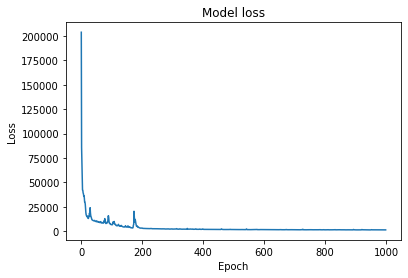

In [14]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

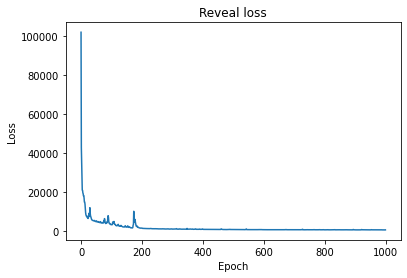

In [15]:
# Plot Secret Image Loss through epochs
plt.plot(reveal_loss_history)
plt.title('Reveal loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [16]:
# Load model
from keras.models import model_from_json
# load json and create model
json_file = open('multi_steg.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("multi_steg_weights.h5")
print("Loaded model from disk")

Loaded model from disk


## Results

In [17]:
# Retrieve decoded predictions.
decoded = loaded_model.predict(input_S_list+[input_C])

decoded_S_list = []
idx = 0
for i in range(n_secret):
    decoded_S= decoded[..., idx:idx+3]
    print(decoded_S.shape)
    decoded_S_list.append(decoded_S)
    idx+=3
    
# decoded_S1, decoded_S2, decoded_C = decoded[...,0:3], decoded[...,3:6], decoded[...,6:9]
decoded_C = decoded[..., idx:idx+3]

# Get absolute difference between the outputs and the expected values.
diff_S_list = []
for i in range(n_secret):
    diff_S = np.abs(decoded_S_list[i] - input_S_list[i])
    diff_S_list.append(diff_S)
    
diff_C = np.abs(decoded_C - input_C) 

(200, 64, 64, 3)
(200, 64, 64, 3)


In [18]:
def pixel_errors(input_S_list, input_C, decoded_S_list, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel_list = []
    for input_S, decoded_S in zip(input_S_list, decoded_S_list): 
        see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
        see_Spixel_list.append(see_Spixel)
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel_list,  see_Cpixel

def pixel_histogram(diff_S_list, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    for _ in diff_S_list:
        diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(n_secret*5+5, 5))
    a=fig.add_subplot(1,n_secret+1,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, density = True, alpha=0.75)
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    
    a=fig.add_subplot(1,3,2)
    imgplot = plt.hist(255* diff_S1flat, 100, density = True, alpha=0.75)
    a.set_title('Distribution of errors in first Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,3,3)
    imgplot = plt.hist(255* diff_S2flat, 100, density = True, alpha=0.75)
    a.set_title('Distribution of errors in second Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [19]:
# Print pixel-wise average errors in a 256 scale.
S_error_list, C_error = pixel_errors(input_S_list, input_C, decoded_S_list, decoded_C)

for i, S_error in enumerate(S_error_list):
    print (f"#{i} S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

#0 S error per pixel [0, 255]: 10.545587
#1 S error per pixel [0, 255]: 10.844094
C error per pixel [0, 255]: 175.32373


In [20]:
# Plot distribution of errors in cover and secret images.
# pixel_histogram(diff_S1,diff_S2, diff_C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

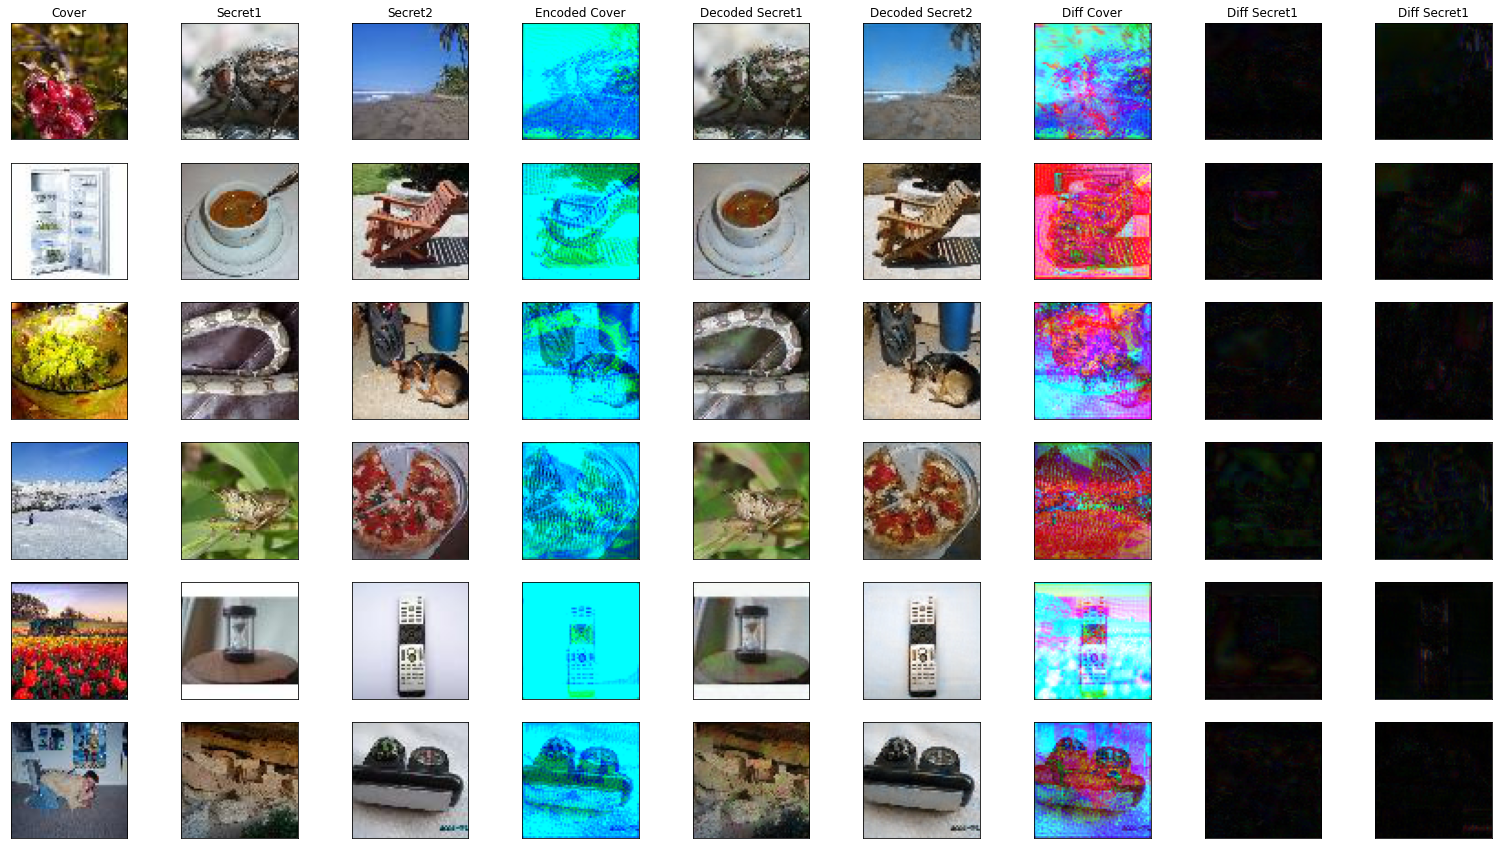

In [21]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

n_col = (n_secret+1)*3 if SHOW_DIFF else (n_secret+1)*3 - 3

plt.figure(figsize=(n_col*3, 15))
rand_indx = [random.randint(0, n_idx) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    
    at_col = 1
    show_image(input_C[idx], n, n_col, i * n_col + at_col, gray=SHOW_GRAY, first_row=i==0, title='Cover')
    at_col+=1

    for j in range(n_secret):
        show_image(input_S_list[j][idx], n, n_col, i * n_col + at_col, gray=SHOW_GRAY, first_row=i==0, title='Secret'+str(j+1))
        at_col+=1
    
    show_image(decoded_C[idx], n, n_col, i * n_col + at_col, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    at_col+=1
    
    for j in range(n_secret):
        show_image(decoded_S_list[j][idx], n, n_col, i * n_col + at_col, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret' + str(j+1))
        at_col+=1

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + at_col, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        at_col+=1
        for j in range(n_secret):
            show_image(np.multiply(diff_S_list[j][idx], ENHANCE), n, n_col, i * n_col + at_col, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret1')
            at_col+=1
#         show_image(np.multiply(diff_S2[idx], ENHANCE), n, n_col, i * n_col + 9, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret2')

plt.show()